# Preprocessing 

Check python version to be Py3.9

In [ ]:
import sys
print("Python:", sys.executable)

Python: c:\Users\lcheu\Documents\BMEN4460_Project\venv\Scripts\python.exe


In [ ]:
#check if GPU is available 
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#import dependencies
import ants
import voxelmorph as vxm
import neurite as ne
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from bias_correction import bias_correct
import time
from affine_registration import affine_reg

## Let's Visualize the Moving Image and Fixed Image in our dataset 

In [4]:
pwd

'c:\\Users\\lcheu\\Documents\\BMEN4460_Project'

In [ ]:
#define project directories 
project_dir = 'c:/Users/lcheu/Documents/BMEN4460_Project'
subject_dir = project_dir + '/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/subject_scans'
template_path = project_dir + '/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_scan/warped_template.nii.gz'

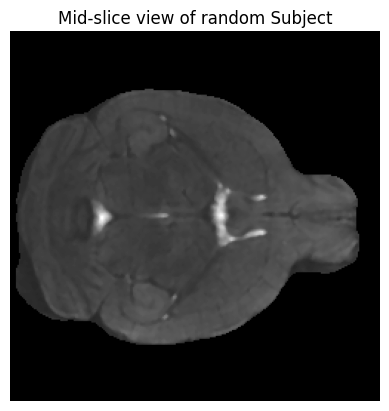

In [ ]:
#visualizing a random subject mid slice 
#load the data path 
img = nib.load(subject_dir + "/20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz")
data = img.get_fdata()

# Plot a mid-slice
mid_slice = data.shape[2] // 2
plt.imshow(data[:, :, mid_slice], cmap='gray')
plt.title("Mid-slice view of random Subject")
plt.axis('off')
plt.show()


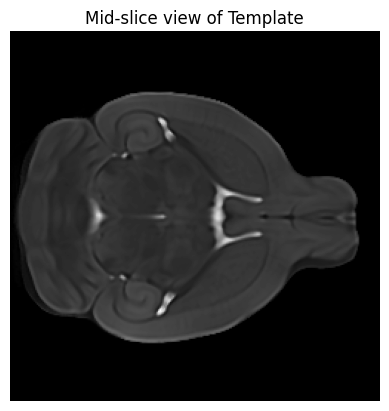

In [ ]:
#Visualizing the template mid slice 
#load template path
img = nib.load(template_path)
data = img.get_fdata()

# Plot a mid-slice
mid_slice = data.shape[2] // 2
plt.imshow(data[:, :, mid_slice], cmap='gray')
plt.title("Mid-slice view of Template")
plt.axis('off')
plt.show()

# Quality Assessment

Let's Check to see if we need to remove any scans with missing slices or bad quality.

In [8]:
#Define the directory with subject scans
count = 0
# Loop through all subject NIfTI files
for filename in os.listdir(subject_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        count += 1
        file_path = os.path.join(subject_dir, filename)
        img = nib.load(file_path)
        print(f"{filename}: {img.shape}")  # Check the shape of each image

print(count)

20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210713_155634_RetromerSRA_PD_hom_g2_04_ID428_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210713_170038_RetromerSRA_Sorla_het_g2_01_ID531_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210714_160840_RetromerSRA_Sorla_hom_g3_01_ID532_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210716_151953_RetromerSRA_Sorla_het_g2_02_ID527_het_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210716_161137_RetromerSRA_Sorla_hom_g3_02_ID528_homo_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210821_172807_RetromerSRA_Sorla_wt_g1_06_ID511_wt_TP1__1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210821_183919_RetromerSRA_Sorla_wt_g1_04_ID509_wt_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 115)
20210821_194309_RetromerSRA_Sorla_wt_g1_

There are some scans with 115 slices while others are 121 slices. Visually looking at these scans, they seem to be fine quality wise. The difference may stem from different protocols or acquisition times. We will keep all of the data. 

In [9]:
template = ants.image_read(template_path) # checking the size of the template
print(template.shape)   

(250, 250, 121)


Since the template scan has 121 scan we should be careful to check that registeration is successful for both affine alignment and resampling to the correct number of slices.

## Preprocessing: N4 Bias Correction 

In [10]:
output_dir = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/bias_corrected"

# Make output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(subject_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(subject_dir, filename)
        output_path = os.path.join(output_dir, f"biascorr_{filename}").replace("\\", "/")  # Normalize path for windows and cmd

        print(f"\nProcessing: {filename}")
        
        start_time = time.time() #lets time the process
        success = bias_correct(input_path, output_path) #bias correction function
        
        elapsed = time.time() - start_time
        if success:
            print(f"✅ Finished {filename} in {elapsed:.2f} seconds")
        else:
            print(f"❌ Failed to process {filename} (after {elapsed:.2f} seconds)")


Processing: 20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
 Bias-corrected image saved to: c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/bias_corrected/biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
✅ Finished 20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz in 5.40 seconds

Processing: 20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
 Bias-corrected image saved to: c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/bias_corrected/biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
✅ Finished 20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz in 5.38 seconds

Processing: 20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz
 Bias-corrected image saved to: c:/Users/lcheu/Documents/BMEN4460_Proje

Let's visualize the Bias Corrected Subject Images

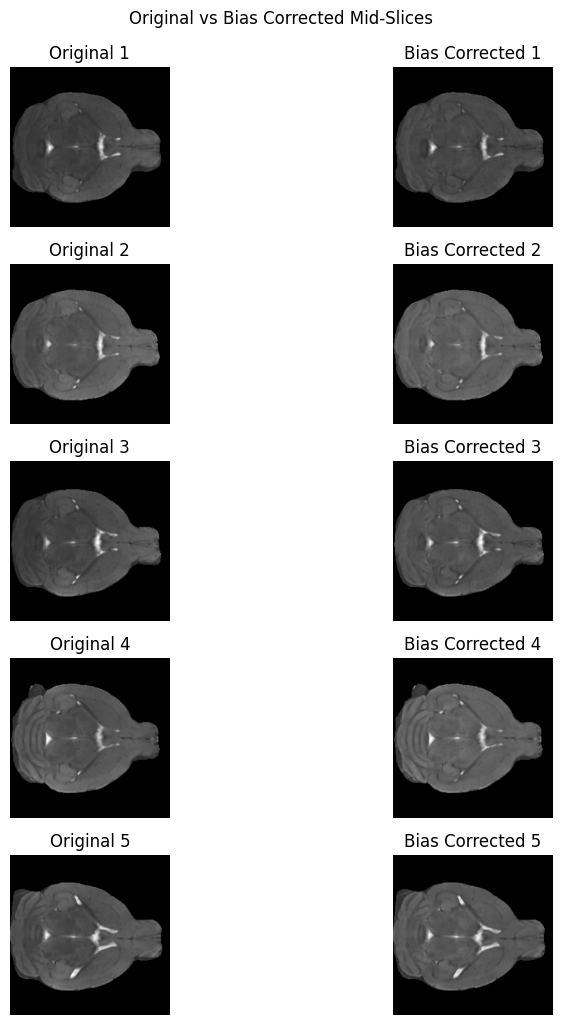

In [11]:
original_dir = subject_dir
bias_dir = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/bias_corrected"

# Get the first 5 original NIfTI files
nifti_files = [f for f in os.listdir(original_dir) if f.endswith(".nii") or f.endswith(".nii.gz")][:5]

# Set up plot: 5 rows (subjects), 2 columns (original vs corrected)
plt.figure(figsize=(10, 10))

for i, filename in enumerate(nifti_files):
    original_path = os.path.join(original_dir, filename)
    corrected_path = os.path.join(bias_dir, f"biascorr_{filename}")

    # Load images
    orig_img = nib.load(original_path).get_fdata()
    corr_img = nib.load(corrected_path).get_fdata()

    # Get mid-slice index
    mid = orig_img.shape[2] // 2

    # Plot original
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(orig_img[:, :, mid], cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Plot corrected
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(corr_img[:, :, mid], cmap='gray')
    plt.title(f"Bias Corrected {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Original vs Bias Corrected Mid-Slices", y=1.02)
plt.show()


# Preprocessing: Skullstripping

In [13]:
template = ants.image_read(template_path)
mask = template > 0.4  # binary mask of brain region; tighter thresholding excludes more non-brain areas, experiment with this value

# Define bias-corrected input and output directories
skstr_dir = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/skull_stripped"
os.makedirs(skstr_dir, exist_ok=True)

# Loop through bias-corrected files
for filename in os.listdir(bias_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        img_path = os.path.join(bias_dir, filename)
        output_path = os.path.join(skstr_dir, f"skstrip_{filename}")

        print(f"Stripping: {filename}")
        try:
            img = ants.image_read(img_path)

            # Resample mask to match image (if needed)
            if img.shape != mask.shape:
                mask_resampled = ants.resample_image(mask, img.shape, use_voxels=True)
            else:
                mask_resampled = mask

            stripped = img * mask_resampled
            ants.image_write(stripped, output_path)
            print(f"✅ Saved: {output_path}")
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")


Stripping: biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
✅ Saved: c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/skull_stripped\skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
Stripping: biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
✅ Saved: c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/skull_stripped\skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
Stripping: biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz
✅ Saved: c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/skull_stripped\skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz
Stripping: biascorr_20210713_155634_RetromerSRA_PD_hom_g2_04_ID428_TP1_

Let visualize the skullstripped scans

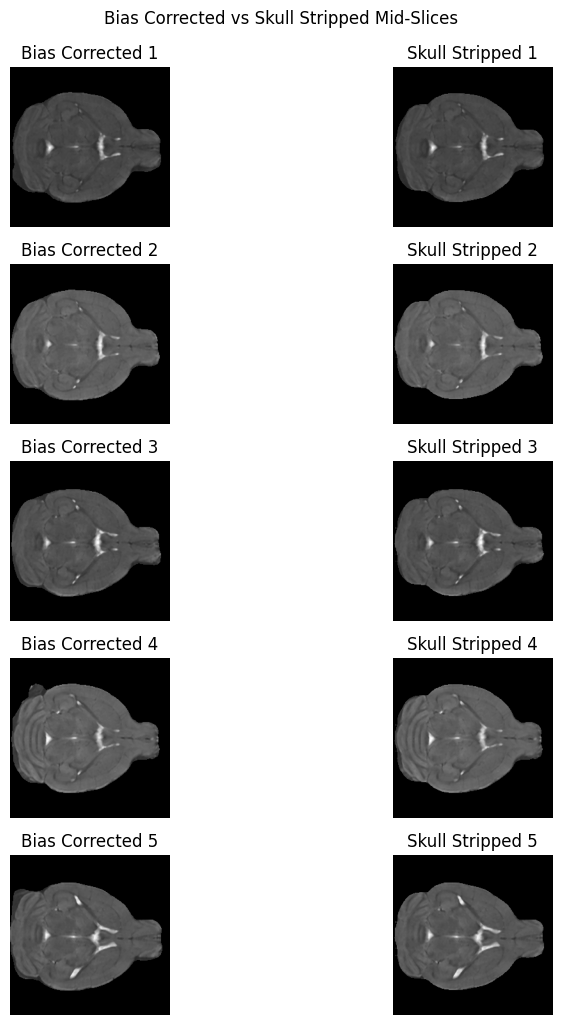

In [14]:
# Get first 5 filenames from bias-corrected folder
nifti_files = [f for f in os.listdir(bias_dir) if f.endswith(".nii") or f.endswith(".nii.gz")][:5]

plt.figure(figsize=(10, 10))

for i, filename in enumerate(nifti_files):
    corr_path = os.path.join(bias_dir, filename)
    skstrip_path = os.path.join(skstr_dir, f"skstrip_{filename}")

    # Load images
    corr_img = nib.load(corr_path).get_fdata()
    sk_img = nib.load(skstrip_path).get_fdata()

    mid = corr_img.shape[2] // 2

    # Bias-corrected
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(corr_img[:, :, mid], cmap='gray')
    plt.title(f"Bias Corrected {i+1}")
    plt.axis('off')

    # Skull-stripped
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(sk_img[:, :, mid], cmap='gray')
    plt.title(f"Skull Stripped {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Bias Corrected vs Skull Stripped Mid-Slices", y=1.02)
plt.show()


# Preprocessing: Affine Alignment

Let's see the difference in alignment (linear) between a subject scan and the template scan 

C:\Users\lcheu\AppData\Local\Temp\ipykernel_36344\3526858691.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for colorbar


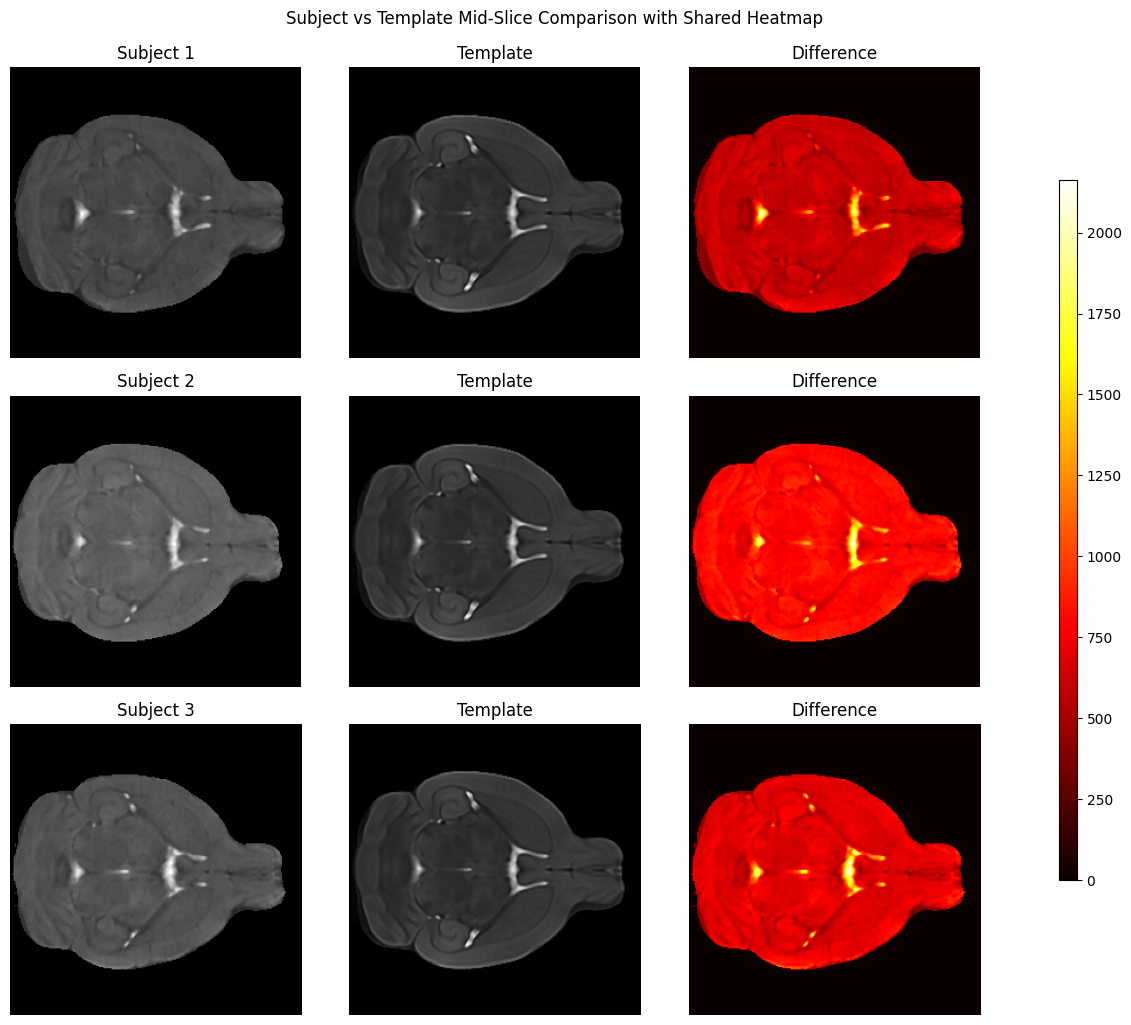

In [18]:
skull_strip = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/skull_stripped"
subject_files = sorted([f for f in os.listdir(skull_strip) if f.endswith(".nii") or f.endswith(".nii.gz")])[:3]
template_path = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_scan/warped_template.nii.gz"
# Load template
template_img = nib.load(template_path).get_fdata()
template_mid = template_img[:, :, template_img.shape[2] // 2]

# Set up figure
fig, axs = plt.subplots(len(subject_files), 3, figsize=(12, 10))
heatmaps = []

# Loop through subjects
for i, fname in enumerate(subject_files):
    subject_path = os.path.join(skull_strip, fname)
    subject_img = nib.load(subject_path).get_fdata()
    subject_mid = subject_img[:, :, subject_img.shape[2] // 2]
    diff_img = np.abs(template_mid - subject_mid)

    axs[i, 0].imshow(subject_mid, cmap='gray')
    axs[i, 0].set_title(f"Subject {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(template_mid, cmap='gray')
    axs[i, 1].set_title("Template")
    axs[i, 1].axis('off')

    im = axs[i, 2].imshow(diff_img, cmap='hot')
    axs[i, 2].set_title("Difference")
    axs[i, 2].axis('off')
    heatmaps.append(im)

# Add a single colorbar for the last heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(heatmaps[-1], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for colorbar
plt.suptitle("Subject vs Template Mid-Slice Comparison with Shared Heatmap", y=1.02)
plt.show()



Lets Start affine Alignment

In [19]:
subject_images_dir = skull_strip  # Directory where all subject images are located
template_path = 'Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_scan/warped_template.nii.gz'
aligned_dir = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/aligned"  # Directory to save the aligned images

# Ensure output directory exists
os.makedirs(aligned_dir, exist_ok=True)

# Get all the subject images in the directory (ensure they are in the right format)
subject_images = [f for f in os.listdir(subject_images_dir) if f.endswith(".nii.gz") or f.endswith(".nii")]

# Print total number of subject images found
print(f"Found {len(subject_images)} subject images to process.\n")

# Loop through each subject image and apply affine registration
for subject_image in subject_images:
    subject_image_path = os.path.join(subject_images_dir, subject_image)
    
    # Print the name of the subject image being processed
    print(f"Processing subject image: {subject_image}...")

    # Define output file path
    output_image_path = os.path.join(aligned_dir, f"aligned_{subject_image}")

    # Perform affine registration
    try:
        affine_reg(template_path, subject_image_path, output_image_path)
        print(f"Successfully aligned: {subject_image}")
    except Exception as e:
        print(f"Error aligning {subject_image}: {e}")
    
    # Print a separator for clarity
    print("-" * 40)
    
print("Affine registration for all subjects completed.")


Found 61 subject images to process.

Processing subject image: skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz...
Registered image saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/aligned\aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
Successfully aligned: skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
----------------------------------------
Processing subject image: skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz...
Registered image saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/aligned\aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
Successfully aligned: skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_

In [ ]:
#Check sizes of images to see if affine alignment + internal resampling was successful 
count = 0
# Loop through all subject NIfTI files
for filename in os.listdir(aligned_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        count += 1
        file_path = os.path.join(aligned_dir, filename)
        img = nib.load(file_path)
        print(f"{filename}: {img.shape}")  # Check the shape of each image

print(count)

aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210713_155634_RetromerSRA_PD_hom_g2_04_ID428_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210713_170038_RetromerSRA_Sorla_het_g2_01_ID531_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210714_160840_RetromerSRA_Sorla_hom_g3_01_ID532_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210716_151953_RetromerSRA_Sorla_het_g2_02_ID527_het_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210716_161137_RetromerSRA_Sorla_hom_g3_02_ID528_homo_TP1_1_1_iso60_WB_mean.nii.gz: (250, 250, 121)
aligned_skstrip_biascorr_20210821_172

Let's visualize the alignment 

C:\Users\lcheu\AppData\Local\Temp\ipykernel_36344\1936262228.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for colorbar


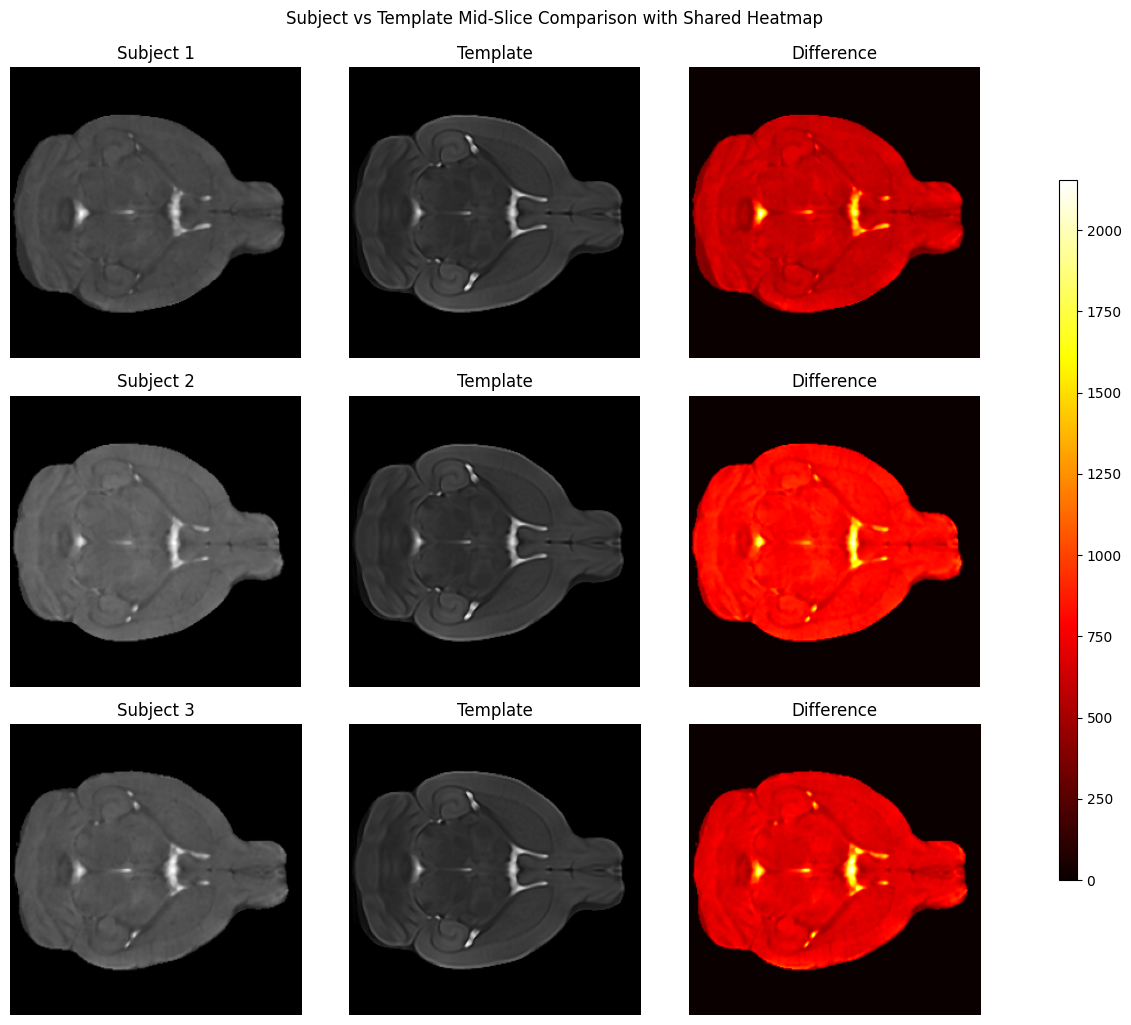

In [21]:
subject_files = sorted([f for f in os.listdir(aligned_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])[:3]

# Load template
template_img = nib.load(template_path).get_fdata()
template_mid = template_img[:, :, template_img.shape[2] // 2]

# Set up figure
fig, axs = plt.subplots(len(subject_files), 3, figsize=(12, 10))
heatmaps = []

# Loop through subjects
for i, fname in enumerate(subject_files):
    subject_path = os.path.join(aligned_dir, fname)
    subject_img = nib.load(subject_path).get_fdata()
    subject_mid = subject_img[:, :, subject_img.shape[2] // 2]
    diff_img = np.abs(template_mid - subject_mid)

    axs[i, 0].imshow(subject_mid, cmap='gray')
    axs[i, 0].set_title(f"Subject {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(template_mid, cmap='gray')
    axs[i, 1].set_title("Template")
    axs[i, 1].axis('off')

    im = axs[i, 2].imshow(diff_img, cmap='hot')
    axs[i, 2].set_title("Difference")
    axs[i, 2].axis('off')
    heatmaps.append(im)

# Add a single colorbar for the last heatmap
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(heatmaps[-1], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for colorbar
plt.suptitle("Subject vs Template Mid-Slice Comparison with Shared Heatmap", y=1.02)
plt.show()



# Preprocessing: Normalization

In [ ]:
#Lets normalize the aligned subject scans 
input_dir = "Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/aligned"
norm_dir = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/normalized"
os.makedirs(norm_dir, exist_ok=True)

# Loop through each resampled image
for filename in os.listdir(input_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(norm_dir, f"normalized_{filename}")

        # Read the image
        img = ants.image_read(input_path)
        img_data = img.numpy()

        # Normalize to [0, 1]
        img_data_norm = (img_data - img_data.min()) / (img_data.max() - img_data.min() + 1e-8)
        
        # Replace image data with normalized data and save
        img_norm = ants.from_numpy(img_data_norm, spacing=img.spacing, origin=img.origin, direction=img.direction)
        img_norm.to_file(output_path)

        print(f"Normalized {filename} and saved to {output_path}")

print("Normalization complete for all resampled images.")

Normalized aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz and saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/normalized\normalized_aligned_skstrip_biascorr_20210709_172801_RetromerSRA_PD_hom_g2_02_ID423_TP1_1_1_iso60_WB_mean.nii.gz
Normalized aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz and saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/normalized\normalized_aligned_skstrip_biascorr_20210712_143510_RetromerSRA_PD_wt_g1_01_ID425_TP1_1_1_iso60_WB_mean.nii.gz
Normalized aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_ID426_TP1_1_1_iso60_WB_mean.nii.gz and saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/normalized\normalized_aligned_skstrip_biascorr_20210712_143641_RetromerSRA_PD_wt_g1_02_I

In [ ]:
#Lets also normalize the template 
input_dir = "C:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_scan"
template_path = project_dir + "/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_normalized"
os.makedirs(template_path, exist_ok=True)

# Loop through each resampled image
for filename in os.listdir(input_dir):
    if filename.endswith(".nii") or filename.endswith(".nii.gz"):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(template_path, f"normalized_{filename}")

        # Read the image
        img = ants.image_read(input_path)
        img_data = img.numpy()

        # Normalize to [0, 1]
        img_data_norm = (img_data - img_data.min()) / (img_data.max() - img_data.min() + 1e-8)
        
        # Replace image data with normalized data and save
        img_norm = ants.from_numpy(img_data_norm, spacing=img.spacing, origin=img.origin, direction=img.direction)
        img_norm.to_file(output_path)

        print(f"Normalized {filename} and saved to {output_path}")

print("Normalization complete for all resampled images.")

Normalized warped_template.nii.gz and saved to c:/Users/lcheu/Documents/BMEN4460_Project/Mouse_dataset/Mouse_dataset/RT_SRA_MouseMRIRegistration/template_normalized\normalized_warped_template.nii.gz
Normalization complete for all resampled images.
